In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
input_path = "../input/"

# Any results you write to the current directory are saved as output.

['database.sqlite', 'product_descriptions.csv', 'attributes.csv', 'train.csv', 'sample_submission.csv', 'test.csv', 'relevance_instructions.docx']


# LOAD

In [2]:
train = pd.read_csv(input_path + "train.csv", engine="python") 
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


# EDA

In [3]:
train.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [4]:
train.isna().sum()

id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

In [5]:
scores = train.iloc[:, 4].round(0)
scores.value_counts()

2.0    34614
3.0    34338
1.0     5115
Name: relevance, dtype: int64

# HELPERS

In [6]:
# LONGEST COMMON SUBSTRING
# Python program to find Longest Common Sub-string 
from difflib import SequenceMatcher 
def matchsubstring(m,n): 
    seqMatch = SequenceMatcher(None,m,n) 
    match = seqMatch.find_longest_match(0, len(m), 0, len(n)) 
    return m[match.a: match.a + match.size]
    
        


# FEATURE ENGINEERING

In [7]:
dataset = []
for i in range(train.shape[0]):
    desc = train.iloc[i, 2]
    query = train.iloc[i, 3]
    score = train.iloc[i,4]
    lcs = matchsubstring(desc.lower(), query.lower()) # longest common substring
    #if len(lcs)>2:
    #    overlap = len(lcs)
    #else:
    #    overlap = 0
    overlap = len(lcs)
    dataset.append([overlap, score])
dataset = np.array(dataset)
    
print(dataset.shape)

(74067, 2)


# DATASET PREPARATION

In [8]:
from sklearn.model_selection import train_test_split
X, y = [dataset[:, 0], dataset[:, 1]]
X = X.reshape(X.shape[0], 1)
y = y
print(X.shape, y.shape, dataset.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(74067, 1) (74067,) (74067, 2)


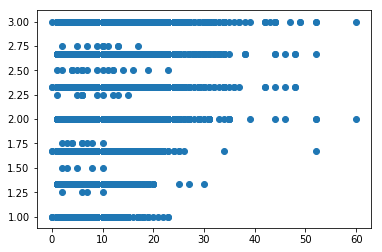

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X, y, alpha=1)
plt.show()

# BASELINE MODEL

In [10]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)


In [11]:
from sklearn.ensemble import RandomForestRegressor 
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [12]:
#from sklearn.linear_model import LinearRegression
#model = LinearRegression()
#model.fit(X_train, y_train)
#y_preds = model.predict(X_test)

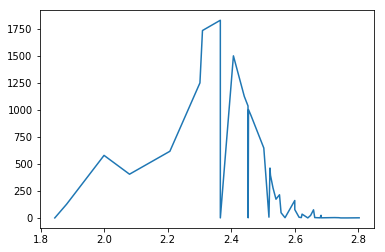

In [13]:
y_preds[y_preds>3] = 3
values = pd.Series(y_preds).value_counts() 
values.sort_index().plot(kind='line')

# EVALUATION

In [14]:
#RMSE
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_preds, y_test))

0.5130499275097299

In [15]:
# naive submission test
np.sqrt(mean_squared_error(np.zeros(14814)+3, y_test))

0.815684128037821

### Baseline, RMSE - 0.513, while: 
* best score on lb: 0.431
* all 1 submission score: 1.481
* all 2 submission score: 0.655
* all 3 submission score: 0.815

# INFERENCE DATA LOAD

In [16]:
submission = pd.read_csv(input_path + "test.csv", engine="python")
dataset = []
for i in range(submission.shape[0]):
    desc =  submission.iloc[i, 2]
    query = submission.iloc[i, 3]
    lcs = matchsubstring(desc.lower(), query.lower()) # longest common substring
    overlap = len(lcs)
    dataset.append([overlap])
dataset = np.array(dataset)
dataset.shape

(166693, 1)

# INFERENCE

In [17]:
res = model.predict(dataset)
pd.Series(res).value_counts() 

2.309462    20207
2.365634    19982
2.406777    16358
2.301461    14843
2.441029    12511
2.452665    10876
2.454249    10558
2.462326     9938
2.206912     7820
2.502376     7213
1.999795     7108
2.521810     5316
2.523382     4793
2.079920     4397
2.531270     3152
2.551751     2385
2.540682     2096
1.882113     1874
2.599774     1293
2.599855      914
2.658797      745
2.556632      555
2.622734      368
2.649615      286
2.682440      262
2.613290      163
2.518549      156
2.662606       92
2.620385       81
2.453186       60
2.569123       46
2.251601       42
1.844865       30
2.534633       24
2.724975       21
2.738695       21
2.810939       19
2.679542       13
2.640806       12
2.802335        9
2.764841        9
2.683029        9
2.719311        7
2.365648        6
2.498870        4
2.381549        4
2.744249        4
2.741635        4
2.801268        3
2.641521        2
2.539877        2
dtype: int64

# OUTPUT

In [18]:
res[res>3] = 3
res = pd.DataFrame(res, columns=['relevance'])
res['id'] = submission['id']
res = res[['id', 'relevance']]
res.head()

,id,relevance
0,1,1.999795
1,4,1.882113
2,5,2.441029
3,6,2.521810
4,7,2.521810


In [19]:
res.loc[res['relevance']>=3]

,id,relevance


In [20]:
res.to_csv('output.csv', index=False)

In [21]:
tmp = pd.read_csv("output.csv")
tmp.loc[tmp['relevance']>3]

,id,relevance


In [22]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 2 columns):
id           166693 non-null int64
relevance    166693 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.5 MB


In [23]:
!head output.csv 

id,relevance
1,1.9997946306581225
4,1.8821127272219056
5,2.4410288422358013
6,2.521810228597511
7,2.521810228597511
8,1.9997946306581225
10,2.599774029879965
11,2.365633816042012
12,2.365633816042012
